In [1]:
# Download the game and modules

!pip install gym_super_mario_bros
!pip install nes_py
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install stable-baselines3[extra]

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# Import the game and joypad

import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Clean up the controls as we only need right, jump and run to clear the first stage.

COMPLEX_MOVEMENT.pop(0)
COMPLEX_MOVEMENT.pop(0)
COMPLEX_MOVEMENT.pop(0)
COMPLEX_MOVEMENT.pop(2)
COMPLEX_MOVEMENT.pop(2)
COMPLEX_MOVEMENT.pop(2)
COMPLEX_MOVEMENT.pop(2)
COMPLEX_MOVEMENT.pop(2)
COMPLEX_MOVEMENT.pop(2)
COMPLEX_MOVEMENT

[['right', 'B'], ['right', 'A', 'B']]

In [4]:
# Setting up the game

env = gym_super_mario_bros.make('SuperMarioBros2-v0',apply_api_compatibility=True,render_mode="human")
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [5]:
# Creating a window to run the game

done = True
for step in range (500):
    if done:
        env.reset()
    state, reward, done, info, game_details = env.step(env.action_space.sample())
    env.render()
env.close()

In [6]:
# Import modules to stack the frames, which gives memory to the model, and grey-scale the input

from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [7]:
# Create the new grey-scaled and stacked environment

env = gym_super_mario_bros.make('SuperMarioBros2-v0',apply_api_compatibility=True,render_mode="human")
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [12]:
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)
state = env.reset()
state, reward, done, info = env.step([1])

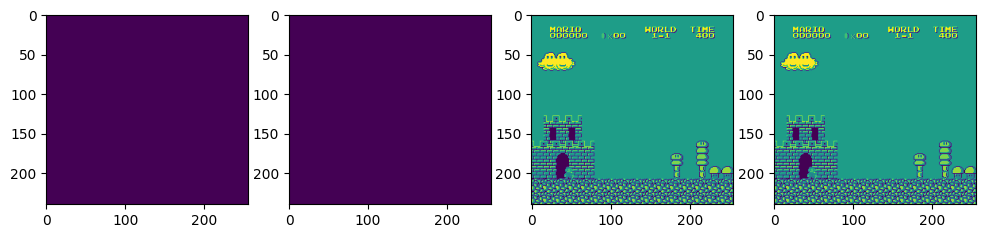

In [13]:
# Looking at what the model will see

plt.figure(figsize=(12,10))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [14]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [15]:
# Class for training and storing the model

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [16]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [17]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512) 
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=5000000, callback=callback)
model.save('thisisatestmodel')

Using cpu device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/PPO_1
----------------------------
| time/              |     |
|    fps             | 29  |
|    iterations      | 1   |
|    time_elapsed    | 17  |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 2            |
|    time_elapsed         | 137          |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0024535963 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.00183      |
|    learning_rate        | 1e-05        |
|    loss                 | 69.5         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000743    |
|    value_loss           |

In [18]:
# loading the model

model = PPO.load('./train/best_model_20000')

In [20]:
state = env.reset()
while True: 
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 